### Carga de datos

In [118]:
# Importamos librerías necesarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import seaborn as sns

### Experimentación con el dataset: Covid19Casos

##### Dataset - Covid19Casos
- Source: http://datos.salud.gob.ar/dataset/covid-19-casos-registrados-en-la-republica-argentina/archivo/fd657d02-a33a-498b-a91b-2ef1a68b8d16

In [119]:
url = 'https://sisa.msal.gov.ar/datos/descargas/covid-19/files/Covid19Casos.csv'

df = pd.read_csv(url, error_bad_lines=False)

In [120]:
dataset = df.copy(deep=True)

In [121]:
dataset.head(10)

,id_evento_caso,sexo,edad,edad_años_meses,residencia_pais_nombre,residencia_provincia_nombre,residencia_departamento_nombre,carga_provincia_nombre,fecha_inicio_sintomas,fecha_apertura,...,fecha_fallecimiento,asistencia_respiratoria_mecanica,carga_provincia_id,origen_financiamiento,clasificacion,clasificacion_resumen,residencia_provincia_id,fecha_diagnostico,residencia_departamento_id,ultima_actualizacion
0,1000000,M,53.0,Años,Argentina,CABA,SIN ESPECIFICAR,Buenos Aires,NaN,2020-06-01,...,NaN,NO,6,Privado,Caso Descartado,Descartado,2,2020-06-09,0,2020-10-29
1,1000002,M,21.0,Años,Argentina,Buenos Aires,La Matanza,Buenos Aires,NaN,2020-06-01,...,NaN,NO,6,Público,Caso Descartado,Descartado,6,2020-06-01,427,2020-10-29
2,1000003,F,40.0,Años,Argentina,Córdoba,Capital,Córdoba,2020-05-24,2020-06-01,...,NaN,NO,14,Privado,Caso Descartado,Descartado,14,2020-06-01,14,2020-10-29
3,1000005,F,58.0,Años,Argentina,Mendoza,Las Heras,Mendoza,NaN,2020-06-01,...,NaN,NO,50,Público,Caso Descartado,Descartado,50,2020-06-01,49,2020-10-29
4,1000006,M,28.0,Años,Argentina,Buenos Aires,Malvinas Argentinas,Buenos Aires,2020-05-30,2020-06-01,...,NaN,NO,6,Público,Caso sospechoso - No Activo - Con muestra sin ...,Sospechoso,6,NaN,515,2020-10-29
5,1000007,M,26.0,Años,Argentina,Formosa,Patiño,Formosa,NaN,2020-06-01,...,NaN,NO,34,Público,Caso confirmado por laboratorio - No Activo po...,Confirmado,34,2020-06-25,35,2020-10-29
6,1000008,F,69.0,Años,Argentina,CABA,SIN ESPECIFICAR,CABA,2020-05-31,2020-06-01,...,NaN,NO,2,Privado,Caso Descartado,Descartado,2,2020-06-01,0,2020-10-29
7,1000009,M,73.0,Años,Argentina,Buenos Aires,Esteban Echeverría,Buenos Aires,2020-05-31,2020-06-01,...,NaN,NO,6,Privado,Caso Descartado,Descartado,6,2020-06-02,260,2020-10-29
8,1000010,M,7.0,Años,Argentina,CABA,COMUNA 07,CABA,NaN,2020-06-01,...,NaN,NO,2,Público,Caso confirmado por laboratorio - No activo (p...,Confirmado,2,2020-06-01,7,2020-10-29
9,1000011,M,42.0,Años,Argentina,Santa Fe,Rosario,Santa Fe,NaN,2020-06-01,...,NaN,NO,82,Público,Caso Descartado,Descartado,82,2020-06-01,84,2020-10-29


## Limpieza, Preprocesado y Feature Engineering

### Edad

In [122]:
# Paso meses a años (cuando la edad está expresada en meses)
dataset['edad'].loc[dataset.edad_años_meses == 'Meses'] = 0

In [123]:
# Eliminamos la columna edad_años_meses
dataset.drop(['edad_años_meses'], axis=1, inplace=True)

### Lugares

#### País<br/>
- Se conservan sólo los datos de personas residentes en Argentina

In [124]:
dataset.drop(dataset[dataset.residencia_pais_nombre != "Argentina"].index, inplace=True)

In [125]:
#Elimino la columna país porque todos los registros tienen el mismo valor
dataset.drop(['residencia_pais_nombre'], axis=1, inplace=True)

#### Provincia

In [126]:
#Se elimina la variable carga_provincia_nombre
dataset.drop(['carga_provincia_nombre'], axis=1, inplace=True)

In [127]:
#Se quitan los registros con provincia "SIN ESPECIFICAR"
dataset.drop(dataset[dataset.residencia_provincia_nombre == "SIN ESPECIFICAR"].index, inplace=True)

## Clustering

### Pre-procesamiento del dataset<br />
Se divide el dataset principal en cuatro sub dataset agrupando por provincia de acuerdo a las siguientes variables de interés:
- Casos confirmados
- Fallecidos
- Cantidad de casos en cuidados intensivos
- Cantidad de casos con asistencia respiratoria mecánica

In [148]:
# Dataset de confirmados por provincia
ds_confirmados = dataset[(dataset["clasificacion_resumen"] == "Confirmado")].groupby(['residencia_provincia_nombre']).size().reset_index(name='confirmados')
ds_confirmados.reset_index(inplace=True)

In [149]:
# Dataset de fallecidos por provincia
ds_fallecidos = dataset[(dataset["fallecido"] == "SI")].groupby(['residencia_provincia_nombre']).agg({'residencia_provincia_nombre':'size', 'edad':'mean'}).rename(columns={'residencia_provincia_nombre':'fallecidos','edad':'edad_promedio'})
ds_fallecidos.reset_index(inplace=True)

In [150]:
# Dataset de cuidados intensivos por provincia
ds_cuidado_intensivo = dataset[(dataset["cuidado_intensivo"] == "SI")].groupby(['residencia_provincia_nombre']).size().reset_index(name='cuidado_intensivo')
ds_cuidado_intensivo.reset_index(inplace=True)

In [151]:
# Dataset de cuidados intensivos por provincia
ds_asistencia_respiratoria = dataset[(dataset["asistencia_respiratoria_mecanica"] == "SI")].groupby(['residencia_provincia_nombre']).size().reset_index(name='asistencia_respiratoria_mecanica')
ds_asistencia_respiratoria.reset_index(inplace=True)

Luego, se hace combinan los cuatro sub datasets en un dataset final, el cual se utilizará para los algoritmos de clustering.

In [152]:
dataset_final = ds_confirmados.merge(ds_fallecidos).merge(ds_cuidado_intensivo).merge(ds_asistencia_respiratoria)
dataset_final.drop(['index'], axis=1, inplace=True)

In [153]:
dataset_final.head(5)

,residencia_provincia_nombre,confirmados,fallecidos,edad_promedio,cuidado_intensivo,asistencia_respiratoria_mecanica
0,Buenos Aires,524923,19864,71.603023,13726,5320
1,CABA,142120,5924,76.635641,5127,2152
2,Catamarca,694,1,97.000000,35,10
3,Chaco,12257,549,65.318761,994,435
4,Chubut,13095,192,69.625000,174,77


### Análisis de correlación entre las variables del dataset final

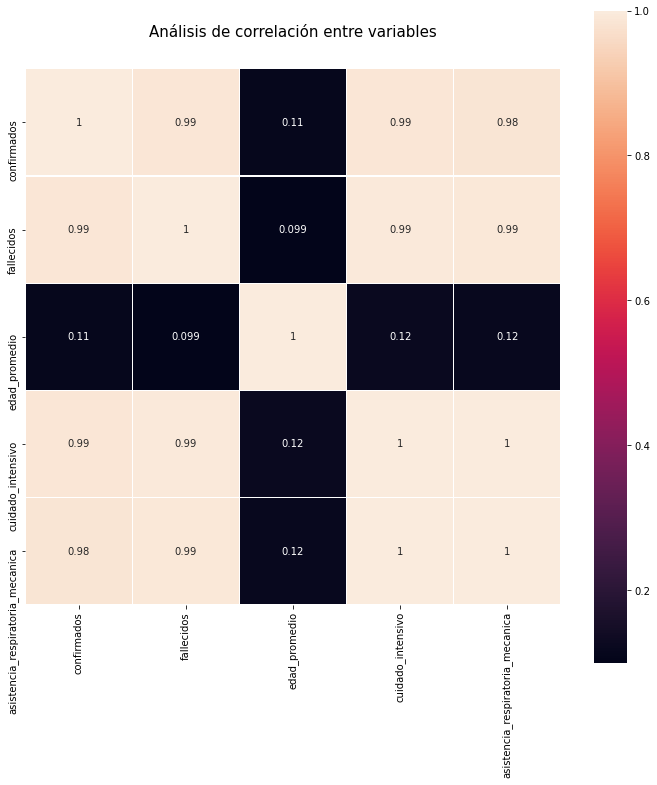

In [154]:
plt.figure(figsize=(12,12))
plt.title('Análisis de correlación entre variables', y=1.05, size=15)
sns.heatmap(dataset_final.corr(), linewidths=0.1,vmax=1.0, square=True, linecolor='white', annot=True)

## Clustering con K-Means

In [155]:
from sklearn.cluster import KMeans,MeanShift
from sklearn import decomposition


### Definición del array de variables a utilizar en el algoritmo

In [166]:
values = ["confirmados", "fallecidos", "edad_promedio", "cuidado_intensivo", "asistencia_respiratoria_mecanica"]
dataset_km = dataset_final[values]
dataset_km

,confirmados,fallecidos,edad_promedio,cuidado_intensivo,asistencia_respiratoria_mecanica
0,524923,19864,71.603023,13726,5320
1,142120,5924,76.635641,5127,2152
2,694,1,97.000000,35,10
3,12257,549,65.318761,994,435
4,13095,192,69.625000,174,77
5,2419,47,67.787234,84,45
6,76510,1258,73.162957,1933,497
7,14644,456,71.291667,433,164
8,143,3,64.333333,44,26
9,16413,745,66.697581,187,116


### Análisis y búsqueda del número óptimo de clusters a través de Inertia

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

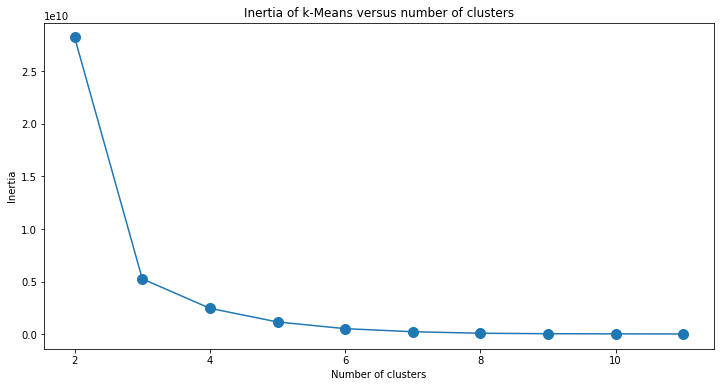

In [167]:
scores = [KMeans(n_clusters=i+2).fit(dataset_km).inertia_ for i in range(10)]

from matplotlib import pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(np.arange(2, 12), scores,'-o', markersize=10)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

### Implementación del algoritmo

In [159]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(dataset_km)
y_kmeans1=y_kmeans+1
cluster = pd.DataFrame(y_kmeans1)
dataset_km_sub = dataset_final.drop(['residencia_provincia_nombre'], axis=1)
# Adding cluster to the Dataset
dataset_km_sub['cluster'] = cluster
#Mean of clusters
kmeans_mean_cluster = pd.DataFrame(round(dataset_km_sub.groupby('cluster').mean(),1))

clusters = kmeans.labels_

## Identificación de los valores promedio (centroides) 
kmeans_mean_cluster

,confirmados,fallecidos,edad_promedio,cuidado_intensivo,asistencia_respiratoria_mecanica
cluster,,,,,
1,12678.0,330.2,69.3,266.5,123.2
2,524923.0,19864.0,71.6,13726.0,5320.0
3,106420.3,2840.0,74.4,2844.3,1102.0


In [160]:
dataset_km_sub_concat = pd.concat([dataset_final[['residencia_provincia_nombre']],dataset_km_sub],axis=1)

In [169]:
dataset_km_sub_concat.head(10)

,residencia_provincia_nombre,confirmados,fallecidos,edad_promedio,cuidado_intensivo,asistencia_respiratoria_mecanica,cluster
0,Buenos Aires,524923,19864,71.603023,13726,5320,2
1,CABA,142120,5924,76.635641,5127,2152,3
2,Catamarca,694,1,97.000000,35,10,1
3,Chaco,12257,549,65.318761,994,435,1
4,Chubut,13095,192,69.625000,174,77,1
5,Corrientes,2419,47,67.787234,84,45,1
6,Córdoba,76510,1258,73.162957,1933,497,3
7,Entre Ríos,14644,456,71.291667,433,164,1
8,Formosa,143,3,64.333333,44,26,1
9,Jujuy,16413,745,66.697581,187,116,1


In [189]:
import plotly.express as px
fig = px.treemap(dataset_km_sub_concat, path=['cluster', 'residencia_provincia_nombre'], values='edad_promedio')
fig.update_layout(autosize=False,width=800,height=700)

fig.show()

In [174]:
data=[]

kmean_clusters = go.Scatter(x=dataset_km["fallecidos"], y=dataset_km["edad_promedio"],
                                mode='markers',
                                text= dataset_final.loc[:,'residencia_provincia_nombre'],
                                marker=dict(
                                size=8,
                                color = clusters.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

data=[kmean_clusters]

layout = go.Layout(title="Clustering K means",titlefont=dict(size=20),
                xaxis=dict(title="fallecidos"),
                yaxis=dict(title="edad_promedio"),
                autosize=False, width=600,height=600)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

### Análisis por pairplot

<Figure size 1440x1440 with 0 Axes>

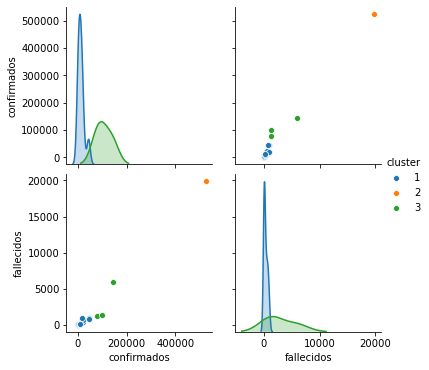

In [175]:
columnas_seleccionadas=["confirmados", "fallecidos"]
plt.figure(figsize=(20,20))
sns.pairplot(data=dataset_km_sub_concat, vars=columnas_seleccionadas, hue='cluster')

### Análisis exploratorio de clusters   

#### Cantidad de observaciones por cluster

In [176]:
dataset_km_sub_concat_count = dataset_km_sub_concat.groupby(by=['cluster']).count()[['residencia_provincia_nombre']]
dataset_km_sub_concat_count.columns = ['observaciones']
dataset_km_sub_concat_count

,observaciones
cluster,
1,20
2,1
3,3


In [186]:
dataset_km_sub_concat[(dataset_km_sub_concat['cluster'] == 1)].head(10)

,residencia_provincia_nombre,confirmados,fallecidos,edad_promedio,cuidado_intensivo,asistencia_respiratoria_mecanica,cluster
2,Catamarca,694,1,97.000000,35,10,1
3,Chaco,12257,549,65.318761,994,435,1
4,Chubut,13095,192,69.625000,174,77,1
5,Corrientes,2419,47,67.787234,84,45,1
7,Entre Ríos,14644,456,71.291667,433,164,1
8,Formosa,143,3,64.333333,44,26,1
9,Jujuy,16413,745,66.697581,187,116,1
10,La Pampa,2807,54,71.648148,86,39,1
11,La Rioja,7105,276,66.811594,122,39,1
12,Mendoza,43806,987,72.209726,606,305,1


In [187]:
dataset_km_sub_concat[(dataset_km_sub_concat['cluster'] == 2)]

,residencia_provincia_nombre,confirmados,fallecidos,edad_promedio,cuidado_intensivo,asistencia_respiratoria_mecanica,cluster
0,Buenos Aires,524923,19864,71.603023,13726,5320,2


In [188]:
dataset_km_sub_concat[(dataset_km_sub_concat['cluster'] == 3)].head(4)

,residencia_provincia_nombre,confirmados,fallecidos,edad_promedio,cuidado_intensivo,asistencia_respiratoria_mecanica,cluster
1,CABA,142120,5924,76.635641,5127,2152,3
6,Córdoba,76510,1258,73.162957,1933,497,3
20,Santa Fe,100631,1338,73.343797,1473,657,3
